
Deep Learning (LSTM) CITY predictor for ALL variables:
PM25, PM10, NO2, SO2, O3, CO, NOX, WS, WD, AT, RH, BP, SolarRad, Rain

Predicts 1-hour ahead (lead1): value at t+1

Uses:
clean/cea_hourly_2019_2024_clean_dl_md.csv

Saves:
city_predictor_model_dl_md/
dl_city_predictor_<TARGET>_lead1.keras
dl_preprocess_<TARGET>_lead1.joblib
dl_config_<TARGET>_lead1.json

Run:
(airvenv) python train_city_predictor_dl.py


In [2]:
from pathlib import Path
import json
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import dump

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


In [3]:
# -----------------------------
# Settings
# -----------------------------
CSV = Path("clean/cea_hourly_2019_2024_clean_dl_md.csv")
OUT = Path("city_predictor_model_dl_md")
OUT.mkdir(exist_ok=True)


In [4]:
# ✅ Train a model per target (all variables)
BASE_TARGETS = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
]

STATION_META = {
    "Battaramulla": {"lat": 6.901035, "lon": 79.926513},
    "Kandy":        {"lat": 7.292651, "lon": 80.635649},
}


In [5]:
# Physical plausibility bounds (used only for optional clamping in UI; training uses raw cleaned)
BOUNDS = {
    "PM25": (0, 1000),
    "PM10": (0, 1500),
    "NO2": (0, 1000),
    "SO2": (0, 1000),
    "O3": (0, 1000),
    "CO": (0, 50000),
    "NOX": (0, 2000),
    "WS": (0, 60),
    "WD": (0, 360),
    "AT": (-5, 50),
    "RH": (0, 100),
    "BP": (800, 1100),
    "SolarRad": (0, 1400),
    "Rain": (0, 500),
}


In [ ]:
WINDOW = 24
TEST_MONTHS = 6
BATCH = 256
EPOCHS = 50
SEED = 42

# Lags / rolls
LAGS  = (1, 3, 6, 12, 24)
ROLLS = (3, 6, 24)

tf.random.set_seed(SEED)
np.random.seed(SEED)


In [7]:
# -----------------------------
# Feature helpers
# -----------------------------
def add_wind_components(df: pd.DataFrame) -> pd.DataFrame:
    # WD degrees, WS m/s
    rad = np.deg2rad(df["WD"].astype(float))
    df["u"] = df["WS"].astype(float) * np.cos(rad)
    df["v"] = df["WS"].astype(float) * np.sin(rad)
    return df

def add_lag_roll_features(df: pd.DataFrame, cols, lags=LAGS, rolls=ROLLS) -> pd.DataFrame:
    """
    Adds lag and rolling mean features per station.
    Rolling means are shifted by 1 hour so they use past-only values.
    """
    df = df.sort_values(["station", "datetime"]).copy()

    for col in cols:
        if col not in df.columns:
            continue

        for L in lags:
            df[f"{col}_lag{L}"] = df.groupby("station")[col].shift(L)

        for W in rolls:
            past = df.groupby("station")[col].shift(1)
            df[f"{col}_roll{W}"] = (
                past.groupby(df["station"])
                    .rolling(W, min_periods=max(1, W // 2))
                    .mean()
                    .reset_index(level=0, drop=True)
            )
    return df

def metrics(y, p):
    mse = mean_squared_error(y, p)
    rmse = float(np.sqrt(mse))
    mae = float(mean_absolute_error(y, p))
    r2  = float(r2_score(y, p))
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def seq_from_arrays(X: np.ndarray, y: np.ndarray, window: int):
    if len(y) < window:
        return None, None
    Xs, ys = [], []
    for i in range(window - 1, len(y)):
        Xs.append(X[i - window + 1 : i + 1])
        ys.append(y[i])
    return np.stack(Xs), np.array(ys)


In [8]:
# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv(CSV, parse_dates=["datetime"])

needed = [
    "station", "datetime", "lat", "lon",
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
    "month","day",
    "hour","hour_sin","hour_cos"
]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise SystemExit(f"Missing columns in CSV: {missing}. Run app.py cleaner first.")

df = df[needed].copy()


In [9]:
# enforce stable lat/lon from metadata
df["lat"] = df["station"].map(lambda s: STATION_META.get(s, {}).get("lat", np.nan))
df["lon"] = df["station"].map(lambda s: STATION_META.get(s, {}).get("lon", np.nan))
df = df.dropna(subset=["lat", "lon"]).copy()

# wind components (u,v)
df = add_wind_components(df)


In [10]:
# -----------------------------
# Lag/Roll columns (use ALL variables)
# -----------------------------
LAG_ROLL_COLS = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
]
df = add_lag_roll_features(df, cols=LAG_ROLL_COLS, lags=LAGS, rolls=ROLLS)


C:\Users\nimas\AppData\Local\Temp\ipykernel_15080\135181436.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{L}"] = df.groupby("station")[col].shift(L)
C:\Users\nimas\AppData\Local\Temp\ipykernel_15080\135181436.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{L}"] = df.groupby("station")[col].shift(L)
C:\Users\nimas\AppData\Local\Temp\ipykernel_15080\135181436.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

In [11]:
# -----------------------------
# Lead1 targets for ALL variables
# -----------------------------
df = df.sort_values(["station", "datetime"]).copy()
for t in BASE_TARGETS:
    df[f"{t}_lead1"] = df.groupby("station")[t].shift(-1)

# Drop NaNs created by lag/roll/lead
df = df.dropna().reset_index(drop=True)


In [12]:
# -----------------------------
# Per-station split (last N months each station)
# -----------------------------
train_parts, test_parts = [], []
split_info = {}

for stn, g in df.groupby("station"):
    g = g.sort_values("datetime").copy()
    last_ts = g["datetime"].max()
    test_start = last_ts - pd.DateOffset(months=TEST_MONTHS)

    tr = g[g["datetime"] < test_start].copy()
    te = g[g["datetime"] >= test_start].copy()

    train_parts.append(tr)
    test_parts.append(te)

    split_info[stn] = {
        "last_ts": str(last_ts),
        "test_start": str(test_start),
        "train_rows": int(len(tr)),
        "test_rows": int(len(te)),
    }

train_df = pd.concat(train_parts, ignore_index=True)
test_df  = pd.concat(test_parts, ignore_index=True)

print("[INFO] Train rows by station:", train_df["station"].value_counts().to_dict())
print("[INFO] Test rows by station :", test_df["station"].value_counts().to_dict())
print("[INFO] WINDOW =", WINDOW)


[INFO] Train rows by station: {'Battaramulla': 48166, 'Kandy': 48166}
[INFO] Test rows by station : {'Battaramulla': 4417, 'Kandy': 4417}
[INFO] WINDOW = 24


In [13]:
# -----------------------------
# Build numeric features (shared for all targets)
# -----------------------------
engineered = []
for c in LAG_ROLL_COLS:
    for L in LAGS:
        engineered.append(f"{c}_lag{L}")
    for W in ROLLS:
        engineered.append(f"{c}_roll{W}")

base_features = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
    "u","v",
    "lat","lon",
    "month","day",
    "hour_sin","hour_cos"
]

num_features = base_features + engineered
num_features = [c for c in num_features if c in train_df.columns]
cat_features = ["station"]


In [14]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ],
    remainder="drop"
)

preprocess.fit(train_df[num_features + cat_features])

X_train_flat = preprocess.transform(train_df[num_features + cat_features]).astype(np.float32)
X_test_flat  = preprocess.transform(test_df[num_features + cat_features]).astype(np.float32)

F = X_train_flat.shape[1]
print("[INFO] Final feature dim F =", F)


[INFO] Final feature dim F = 136


In [15]:
train_df2 = train_df[["station","datetime"]].copy()
test_df2  = test_df[["station","datetime"]].copy()
train_df2["__X"] = list(X_train_flat)
test_df2["__X"]  = list(X_test_flat)


In [ ]:
# -----------------------------
# Train one model per target
# -----------------------------
def train_one_target(base_target: str):
    target = f"{base_target}_lead1"
    print(f"\n[DL] Training target = {target}")

    Xtr_list, ytr_list = [], []
    Xte_list, yte_list = [], []

    stations = sorted(set(train_df2["station"].unique()) | set(test_df2["station"].unique()))

    for stn in stations:
        tr_block = train_df2[train_df2["station"] == stn].sort_values("datetime").copy()
        te_block = test_df2[test_df2["station"] == stn].sort_values("datetime").copy()

        tr_y = train_df[train_df["station"] == stn].sort_values("datetime")[target].to_numpy(dtype=np.float32)
        te_y = test_df[test_df["station"] == stn].sort_values("datetime")[target].to_numpy(dtype=np.float32)

        if len(tr_block) < WINDOW or len(te_block) < WINDOW:
            print(f"[WARN] Skip {stn}: train_rows={len(tr_block)} test_rows={len(te_block)} < WINDOW={WINDOW}")
            continue

        tr_X = np.stack(tr_block["__X"].to_list())
        te_X = np.stack(te_block["__X"].to_list())

        m_tr = min(len(tr_X), len(tr_y))
        m_te = min(len(te_X), len(te_y))
        tr_X, tr_y = tr_X[:m_tr], tr_y[:m_tr]
        te_X, te_y = te_X[:m_te], te_y[:m_te]

        Xs_tr, ys_tr = seq_from_arrays(tr_X, tr_y, WINDOW)
        Xs_te, ys_te = seq_from_arrays(te_X, te_y, WINDOW)

        if Xs_tr is None or Xs_te is None:
            print(f"[WARN] Skip {stn}: sequence build failed")
            continue

        Xtr_list.append(Xs_tr); ytr_list.append(ys_tr)
        Xte_list.append(Xs_te); yte_list.append(ys_te)

        print(f"[OK] {stn}: train_seq={Xs_tr.shape} test_seq={Xs_te.shape}")

    if len(Xtr_list) == 0 or len(Xte_list) == 0:
        raise SystemExit("No valid sequences built. Reduce WINDOW or check station coverage.")

    X_train = np.concatenate(Xtr_list, axis=0)
    y_train = np.concatenate(ytr_list, axis=0)
    X_test  = np.concatenate(Xte_list, axis=0)
    y_test  = np.concatenate(yte_list, axis=0)

    print("[DL] X_train:", X_train.shape, "y_train:", y_train.shape)
    print("[DL] X_test :", X_test.shape,  "y_test :", y_test.shape)

    model = models.Sequential([
        layers.Input(shape=(WINDOW, F)),
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(32),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse"
    )

    cb = [
        callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
    ]

    model.fit(
        X_train, y_train,
        validation_split=0.15,
        epochs=EPOCHS,
        batch_size=BATCH,
        callbacks=cb,
        verbose=1
    )

    pred = model.predict(X_test, verbose=0).reshape(-1)
    m = metrics(y_test, pred)
    print("[DL] TEST metrics:", m)

    # Save
    model_path = OUT / f"dl_city_predictor_{base_target}_lead1.keras"
    prep_path  = OUT / f"dl_preprocess_{base_target}_lead1.joblib"
    cfg_path   = OUT / f"dl_config_{base_target}_lead1.json"

    model.save(model_path)
    dump(preprocess, prep_path)

    with open(cfg_path, "w") as f:
        json.dump({
            "base_target": base_target,
            "target": target,
            "horizon_hours": 1,
            "window": WINDOW,
            "test_months": TEST_MONTHS,
            "lags": list(LAGS),
            "rolls": list(ROLLS),
            "lag_roll_cols": LAG_ROLL_COLS,
            "num_features": num_features,
            "cat_features": cat_features,
            "final_feature_dim": int(F),
            "split_info": split_info,
            "bounds": {k: [float(v[0]), float(v[1])] for k, v in BOUNDS.items()},
            "time_features": {"month": True, "day": True, "hour": "sin_cos"},
        }, f, indent=2)

    print(f"[OK] Saved DL model  → {model_path}")
    print(f"[OK] Saved preprocess→ {prep_path}")
    print(f"[OK] Saved config    → {cfg_path}")


In [17]:
if __name__ == "__main__":
    for tgt in BASE_TARGETS:
        train_one_target(tgt)

    print("\n[DONE] Trained DL lead1 models for:", ", ".join(BASE_TARGETS))



[DL] Training target = PM25_lead1
[OK] Battaramulla: train_seq=(48143, 24, 136) test_seq=(4394, 24, 136)
[OK] Kandy: train_seq=(48143, 24, 136) test_seq=(4394, 24, 136)
[DL] X_train: (96286, 24, 136) y_train: (96286,)
[DL] X_test : (8788, 24, 136) y_test : (8788,)
Epoch 1/40
320/320 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - loss: 111.7687 - val_loss: 24.4974 - learning_rate: 0.0010
Epoch 2/40
320/320 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - loss: 33.2191 - val_loss: 21.3837 - learning_rate: 0.0010
Epoch 3/40
320/320 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - loss: 29.7678 - val_loss: 20.0959 - learning_rate: 0.0010
Epoch 4/40
320/320 ━━━━━━━━━━━━━━━━━━━━ 32s 100ms/step - loss: 28.1727 - val_loss: 19.0747 - learning_rate: 0.0010
Epoch 5/40
320/320 ━━━━━━━━━━━━━━━━━━━━ 35s 108ms/step - loss: 27.3395 - val_loss: 18.1845 - learning_rate: 0.0010
Epoch 6/40
320/320 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step - loss: 26.4483 - val_loss: 18.6701 - learning_rate: 0.0010
Epoch 7/40
320/320 ━━━━━━━━━━━━━━━━━━━━ 31s 96

Evaluation

In [33]:
# -----------------------------
# EVALUATION CELL
# -----------------------------
import numpy as np
import pandas as pd
from joblib import load
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = float(np.mean(np.abs(y_true - y_pred)))
    r2  = float(r2_score(y_true, y_pred))
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

TARGET = "PM25"  # Change to any trained target
WINDOW = 24      # Must match training
LAGS  = (1, 3, 6, 12, 24)
ROLLS = (3, 6, 24)
LAG_ROLL_COLS = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
]

# Load saved model & preprocess
model = load_model(f"city_predictor_model_dl_md/dl_city_predictor_{TARGET}_lead1.keras")
preprocess = load(f"city_predictor_model_dl_md/dl_preprocess_{TARGET}_lead1.joblib")

# Combine last rows of train + full test to compute lag/roll features
history_rows = max(max(LAGS), max(ROLLS))
eval_df = pd.concat([
    train_df.groupby("station").tail(history_rows),
    test_df
], ignore_index=True)

# Add lag/roll + wind components
eval_df = add_lag_roll_features(eval_df, cols=LAG_ROLL_COLS, lags=LAGS, rolls=ROLLS)
eval_df = add_wind_components(eval_df)

# Keep only test rows
eval_df = eval_df[eval_df["datetime"] >= test_df["datetime"].min()].copy()
eval_df = eval_df.dropna().reset_index(drop=True)

# Transform features
num_features = preprocess.transformers_[0][2]
cat_features = preprocess.transformers_[1][2]
eval_df["X"] = list(preprocess.transform(eval_df[num_features + cat_features]).astype(np.float32))

# Build sequences per station
Xs_list, ys_list = [], []
for stn in eval_df["station"].unique():
    stn_df = eval_df[eval_df["station"] == stn].sort_values("datetime")
    X_arr = np.stack(stn_df["X"].to_list())
    y_arr = stn_df[f"{TARGET}_lead1"].to_numpy(dtype=np.float32)
    
    if len(X_arr) < WINDOW:
        continue
    
    Xs, ys = seq_from_arrays(X_arr, y_arr, WINDOW)
    if Xs is not None:
        Xs_list.append(Xs)
        ys_list.append(ys)

X_eval = np.concatenate(Xs_list, axis=0)
y_eval = np.concatenate(ys_list, axis=0)

# Predict and compute metrics
y_pred = model.predict(X_eval, verbose=0).reshape(-1)
m = metrics(y_eval, y_pred)
print(f"[EVAL] {TARGET} metrics:", m)


[EVAL] PM25 metrics: {'MAE': 3.2794229984283447, 'RMSE': 6.053957869343746, 'R2': 0.8168772459030151}


In [34]:
# ------------------------------------------------------------
# Evaluation of all trained DL models (lead1)
# Loads each model and computes test metrics for all pollutants
# ------------------------------------------------------------

from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import load
import tensorflow as tf

# -----------------------------
# Settings
# -----------------------------
CSV = Path("clean/cea_hourly_2019_2024_clean_dl_md.csv")
MODEL_DIR = Path("city_predictor_model_dl_md")

BASE_TARGETS = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
]

STATION_META = {
    "Battaramulla": {"lat": 6.901035, "lon": 79.926513},
    "Kandy":        {"lat": 7.292651, "lon": 80.635649},
}

LAGS = (1, 3, 6, 12, 24)
ROLLS = (3, 6, 24)

# -----------------------------
# Helper functions
# -----------------------------
def add_wind_components(df: pd.DataFrame) -> pd.DataFrame:
    rad = np.deg2rad(df["WD"].astype(float))
    df["u"] = df["WS"].astype(float) * np.cos(rad)
    df["v"] = df["WS"].astype(float) * np.sin(rad)
    return df

def add_lag_roll_features(df: pd.DataFrame, cols, lags=LAGS, rolls=ROLLS) -> pd.DataFrame:
    df = df.sort_values(["station", "datetime"]).copy()
    for col in cols:
        if col not in df.columns:
            continue
        for L in lags:
            df[f"{col}_lag{L}"] = df.groupby("station")[col].shift(L)
        for W in rolls:
            past = df.groupby("station")[col].shift(1)
            df[f"{col}_roll{W}"] = (
                past.groupby(df["station"])
                    .rolling(W, min_periods=max(1, W // 2))
                    .mean()
                    .reset_index(level=0, drop=True)
            )
    return df

def seq_from_arrays(X: np.ndarray, y: np.ndarray, window: int):
    if len(y) < window:
        return None, None
    Xs, ys = [], []
    for i in range(window - 1, len(y)):
        Xs.append(X[i - window + 1 : i + 1])
        ys.append(y[i])
    return np.stack(Xs), np.array(ys)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MSE": mse}

# -----------------------------
# Load and prepare data
# -----------------------------
print("[INFO] Loading data...")
df = pd.read_csv(CSV, parse_dates=["datetime"])

needed = [
    "station", "datetime", "lat", "lon",
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
    "month","day","hour","hour_sin","hour_cos"
]
df = df[needed].copy()

df["lat"] = df["station"].map(lambda s: STATION_META.get(s, {}).get("lat", np.nan))
df["lon"] = df["station"].map(lambda s: STATION_META.get(s, {}).get("lon", np.nan))
df = df.dropna(subset=["lat", "lon"]).copy()

df = add_wind_components(df)

LAG_ROLL_COLS = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
]
df = add_lag_roll_features(df, cols=LAG_ROLL_COLS, lags=LAGS, rolls=ROLLS)

df = df.sort_values(["station", "datetime"]).copy()
for t in BASE_TARGETS:
    df[f"{t}_lead1"] = df.groupby("station")[t].shift(-1)

df = df.dropna().reset_index(drop=True)

# -----------------------------
# Evaluate each model
# -----------------------------
results = []

for base_target in BASE_TARGETS:
    print(f"\n{'='*60}")
    print(f"[EVAL] Evaluating {base_target}")
    print('='*60)
    
    model_path = MODEL_DIR / f"dl_city_predictor_{base_target}_lead1.keras"
    prep_path = MODEL_DIR / f"dl_preprocess_{base_target}_lead1.joblib"
    cfg_path = MODEL_DIR / f"dl_config_{base_target}_lead1.json"
    
    if not model_path.exists() or not prep_path.exists() or not cfg_path.exists():
        print(f"[SKIP] Model files not found for {base_target}")
        continue
    
    # Load config
    with open(cfg_path, "r") as f:
        config = json.load(f)
    
    WINDOW = config["window"]
    TEST_MONTHS = config["test_months"]
    num_features = config["num_features"]
    cat_features = config["cat_features"]
    target = config["target"]
    
    # Load model and preprocessor
    model = tf.keras.models.load_model(model_path)
    preprocess = load(prep_path)
    
    # Split test data (last TEST_MONTHS per station)
    test_parts = []
    for stn, g in df.groupby("station"):
        g = g.sort_values("datetime").copy()
        last_ts = g["datetime"].max()
        test_start = last_ts - pd.DateOffset(months=TEST_MONTHS)
        te = g[g["datetime"] >= test_start].copy()
        test_parts.append(te)
    
    test_df = pd.concat(test_parts, ignore_index=True)
    
    # Preprocess
    X_test_flat = preprocess.transform(test_df[num_features + cat_features]).astype(np.float32)
    
    test_df2 = test_df[["station", "datetime"]].copy()
    test_df2["__X"] = list(X_test_flat)
    
    # Build sequences per station
    Xte_list, yte_list = [], []
    stations = sorted(test_df2["station"].unique())
    
    for stn in stations:
        te_block = test_df2[test_df2["station"] == stn].sort_values("datetime").copy()
        te_y = test_df[test_df["station"] == stn].sort_values("datetime")[target].to_numpy(dtype=np.float32)
        
        if len(te_block) < WINDOW:
            continue
        
        te_X = np.stack(te_block["__X"].to_list())
        m_te = min(len(te_X), len(te_y))
        te_X, te_y = te_X[:m_te], te_y[:m_te]
        
        Xs_te, ys_te = seq_from_arrays(te_X, te_y, WINDOW)
        
        if Xs_te is None:
            continue
        
        Xte_list.append(Xs_te)
        yte_list.append(ys_te)
    
    if len(Xte_list) == 0:
        print(f"[SKIP] No valid test sequences for {base_target}")
        continue
    
    X_test = np.concatenate(Xte_list, axis=0)
    y_test = np.concatenate(yte_list, axis=0)
    
    # Predict
    y_pred = model.predict(X_test, verbose=0).reshape(-1)
    
    # Compute metrics
    metrics_dict = compute_metrics(y_test, y_pred)
    
    print(f"\n[RESULTS] {base_target} (lead1 = 1-hour ahead)")
    print(f"  Test samples: {len(y_test)}")
    print(f"  MAE:  {metrics_dict['MAE']:.4f}")
    print(f"  RMSE: {metrics_dict['RMSE']:.4f}")
    print(f"  R²:   {metrics_dict['R2']:.4f}")
    print(f"  MSE:  {metrics_dict['MSE']:.4f}")
    
    results.append({
        "Pollutant": base_target,
        "Test_Samples": len(y_test),
        "MAE": round(metrics_dict['MAE'], 4),
        "RMSE": round(metrics_dict['RMSE'], 4),
        "R2": round(metrics_dict['R2'], 4),
        "MSE": round(metrics_dict['MSE'], 4),
    })

# -----------------------------
# Summary table
# -----------------------------
print("\n" + "="*80)
print("EVALUATION SUMMARY - ALL POLLUTANTS (1-hour ahead prediction)")
print("="*80)

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Save results
output_path = MODEL_DIR / "evaluation_results_all_pollutants.csv"
results_df.to_csv(output_path, index=False)
print(f"\n[SAVED] Results saved to: {output_path}")

[INFO] Loading data...


C:\Users\nimas\AppData\Local\Temp\ipykernel_15080\767372132.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{L}"] = df.groupby("station")[col].shift(L)
C:\Users\nimas\AppData\Local\Temp\ipykernel_15080\767372132.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{L}"] = df.groupby("station")[col].shift(L)
C:\Users\nimas\AppData\Local\Temp\ipykernel_15080\767372132.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h


[EVAL] Evaluating PM25

[RESULTS] PM25 (lead1 = 1-hour ahead)
  Test samples: 8788
  MAE:  3.2751
  RMSE: 6.0469
  R²:   0.8167
  MSE:  36.5654

[EVAL] Evaluating PM10

[RESULTS] PM10 (lead1 = 1-hour ahead)
  Test samples: 8788
  MAE:  2.5834
  RMSE: 4.4874
  R²:   0.7728
  MSE:  20.1369

[EVAL] Evaluating NO2

[RESULTS] NO2 (lead1 = 1-hour ahead)
  Test samples: 8788
  MAE:  1.2800
  RMSE: 2.2398
  R²:   0.7706
  MSE:  5.0166

[EVAL] Evaluating SO2

[RESULTS] SO2 (lead1 = 1-hour ahead)
  Test samples: 8788
  MAE:  0.3708
  RMSE: 0.6479
  R²:   0.8783
  MSE:  0.4198

[EVAL] Evaluating O3

[RESULTS] O3 (lead1 = 1-hour ahead)
  Test samples: 8788
  MAE:  1.3914
  RMSE: 2.7124
  R²:   0.8972
  MSE:  7.3573

[EVAL] Evaluating CO

[RESULTS] CO (lead1 = 1-hour ahead)
  Test samples: 8788
  MAE:  42.4091
  RMSE: 88.9532
  R²:   0.8910
  MSE:  7912.6763

[EVAL] Evaluating NOX

[RESULTS] NOX (lead1 = 1-hour ahead)
  Test samples: 8788
  MAE:  3.0142
  RMSE: 5.7666
  R²:   0.7609
  MSE:  33.253

In [35]:
# -----------------------------
# PRINT SUMMARY TABLE IN NOTEBOOK
# -----------------------------
if results:
    results_df = pd.DataFrame(results)
    print("\n" + "="*80)
    print("EVALUATION SUMMARY - ALL POLLUTANTS (1-hour ahead prediction)")
    print("="*80)
    display(results_df)  # nicely formatted table in Jupyter/Colab

    print("\nTop-level metrics per pollutant:")
    for _, row in results_df.iterrows():
        print(f"{row['Pollutant']}: Test Samples={row['Test_Samples']}, "
              f"MAE={row['MAE']}, RMSE={row['RMSE']}, R2={row['R2']}, MSE={row['MSE']}")
else:
    print("[INFO] No evaluation results to display.")



EVALUATION SUMMARY - ALL POLLUTANTS (1-hour ahead prediction)


,Pollutant,Test_Samples,MAE,RMSE,R2,MSE
0,PM25,8788,3.2751,6.0469,0.8167,36.5654
1,PM10,8788,2.5834,4.4874,0.7728,20.1369
2,NO2,8788,1.2800,2.2398,0.7706,5.0166
3,SO2,8788,0.3708,0.6479,0.8783,0.4198
4,O3,8788,1.3914,2.7124,0.8972,7.3573
5,CO,8788,42.4091,88.9532,0.8910,7912.6763
6,NOX,8788,3.0142,5.7666,0.7609,33.2537
7,WS,8788,0.0405,0.0753,-0.2206,0.0057
8,WD,8788,4.5576,8.4508,0.5330,71.4163
9,AT,8788,0.6574,2.3130,-0.3022,5.3498



Top-level metrics per pollutant:
PM25: Test Samples=8788, MAE=3.2751, RMSE=6.0469, R2=0.8167, MSE=36.5654
PM10: Test Samples=8788, MAE=2.5834, RMSE=4.4874, R2=0.7728, MSE=20.1369
NO2: Test Samples=8788, MAE=1.28, RMSE=2.2398, R2=0.7706, MSE=5.0166
SO2: Test Samples=8788, MAE=0.3708, RMSE=0.6479, R2=0.8783, MSE=0.4198
O3: Test Samples=8788, MAE=1.3914, RMSE=2.7124, R2=0.8972, MSE=7.3573
CO: Test Samples=8788, MAE=42.4091, RMSE=88.9532, R2=0.891, MSE=7912.6763
NOX: Test Samples=8788, MAE=3.0142, RMSE=5.7666, R2=0.7609, MSE=33.2537
WS: Test Samples=8788, MAE=0.0405, RMSE=0.0753, R2=-0.2206, MSE=0.0057
WD: Test Samples=8788, MAE=4.5576, RMSE=8.4508, R2=0.533, MSE=71.4163
AT: Test Samples=8788, MAE=0.6574, RMSE=2.313, R2=-0.3022, MSE=5.3498
RH: Test Samples=8788, MAE=2.0405, RMSE=3.0796, R2=0.9068, MSE=9.4841
BP: Test Samples=8788, MAE=27.5514, RMSE=28.6206, R2=-0.0763, MSE=819.1395
SolarRad: Test Samples=8788, MAE=14.9338, RMSE=33.2794, R2=0.8576, MSE=1107.521
Rain: Test Samples=8788, MAE

## Compute Train and Validation Metrics

This section loads the saved models and computes metrics on the training and validation sets used during training, without retraining the models.

In [1]:
# -----------------------------
# COMPUTE TRAIN AND VALIDATION METRICS
# -----------------------------
from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import load
import tensorflow as tf

# -----------------------------
# Settings (same as training)
# -----------------------------
CSV = Path("clean/cea_hourly_2019_2024_clean_dl_md.csv")
MODEL_DIR = Path("city_predictor_model_dl_md")

BASE_TARGETS = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
]

STATION_META = {
    "Battaramulla": {"lat": 6.901035, "lon": 79.926513},
    "Kandy":        {"lat": 7.292651, "lon": 80.635649},
}

WINDOW = 24
TEST_MONTHS = 6
LAGS  = (1, 3, 6, 12, 24)
ROLLS = (3, 6, 24)

# -----------------------------
# Helper functions (copied from training)
# -----------------------------
def add_wind_components(df: pd.DataFrame) -> pd.DataFrame:
    rad = np.deg2rad(df["WD"].astype(float))
    df["u"] = df["WS"].astype(float) * np.cos(rad)
    df["v"] = df["WS"].astype(float) * np.sin(rad)
    return df

def add_lag_roll_features(df: pd.DataFrame, cols, lags=LAGS, rolls=ROLLS) -> pd.DataFrame:
    df = df.sort_values(["station", "datetime"]).copy()
    for col in cols:
        if col not in df.columns:
            continue
        for L in lags:
            df[f"{col}_lag{L}"] = df.groupby("station")[col].shift(L)
        for W in rolls:
            past = df.groupby("station")[col].shift(1)
            df[f"{col}_roll{W}"] = (
                past.groupby(df["station"])
                    .rolling(W, min_periods=max(1, W // 2))
                    .mean()
                    .reset_index(level=0, drop=True)
            )
    return df

def seq_from_arrays(X: np.ndarray, y: np.ndarray, window: int):
    if len(y) < window:
        return None, None
    Xs, ys = [], []
    for i in range(window - 1, len(y)):
        Xs.append(X[i - window + 1 : i + 1])
        ys.append(y[i])
    return np.stack(Xs), np.array(ys)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MSE": mse}

# -----------------------------
# Load and prepare data (same as training)
# -----------------------------
print("[INFO] Loading data for train/val metrics...")
df = pd.read_csv(CSV, parse_dates=["datetime"])

needed = [
    "station", "datetime", "lat", "lon",
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
    "month","day",
    "hour","hour_sin","hour_cos"
]
df = df[needed].copy()

df["lat"] = df["station"].map(lambda s: STATION_META.get(s, {}).get("lat", np.nan))
df["lon"] = df["station"].map(lambda s: STATION_META.get(s, {}).get("lon", np.nan))
df = df.dropna(subset=["lat", "lon"]).copy()

df = add_wind_components(df)

LAG_ROLL_COLS = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
]
df = add_lag_roll_features(df, cols=LAG_ROLL_COLS, lags=LAGS, rolls=ROLLS)

df = df.sort_values(["station", "datetime"]).copy()
for t in BASE_TARGETS:
    df[f"{t}_lead1"] = df.groupby("station")[t].shift(-1)

df = df.dropna().reset_index(drop=True)

# -----------------------------
# Per-station split (same as training)
# -----------------------------
train_parts, test_parts = [], []
for stn, g in df.groupby("station"):
    g = g.sort_values("datetime").copy()
    last_ts = g["datetime"].max()
    test_start = last_ts - pd.DateOffset(months=TEST_MONTHS)
    tr = g[g["datetime"] < test_start].copy()
    te = g[g["datetime"] >= test_start].copy()
    train_parts.append(tr)
    test_parts.append(te)

train_df = pd.concat(train_parts, ignore_index=True)
test_df  = pd.concat(test_parts, ignore_index=True)

# -----------------------------
# Build numeric features (shared)
# -----------------------------
engineered = []
for c in LAG_ROLL_COLS:
    for L in LAGS:
        engineered.append(f"{c}_lag{L}")
    for W in ROLLS:
        engineered.append(f"{c}_roll{W}")

base_features = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
    "u","v",
    "lat","lon",
    "month","day",
    "hour_sin","hour_cos"
]

num_features = base_features + engineered
num_features = [c for c in num_features if c in train_df.columns]
cat_features = ["station"]

# -----------------------------
# Evaluate train and val for each model
# -----------------------------
train_val_results = []

for base_target in BASE_TARGETS:
    print(f"\n{'='*60}")
    print(f"[TRAIN/VAL] Computing for {base_target}")
    print('='*60)
    
    model_path = MODEL_DIR / f"dl_city_predictor_{base_target}_lead1.keras"
    prep_path = MODEL_DIR / f"dl_preprocess_{base_target}_lead1.joblib"
    cfg_path = MODEL_DIR / f"dl_config_{base_target}_lead1.json"
    
    if not model_path.exists() or not prep_path.exists() or not cfg_path.exists():
        print(f"[SKIP] Model files not found for {base_target}")
        continue
    
    # Load config
    with open(cfg_path, "r") as f:
        config = json.load(f)
    
    target = config["target"]
    
    # Load model and preprocessor
    model = tf.keras.models.load_model(model_path)
    preprocess = load(prep_path)
    
    # Preprocess train data
    X_train_flat = preprocess.transform(train_df[num_features + cat_features]).astype(np.float32)
    
    train_df2 = train_df[["station","datetime"]].copy()
    train_df2["__X"] = list(X_train_flat)
    
    # Build sequences for train (same as training)
    Xtr_list, ytr_list = [], []
    stations = sorted(set(train_df2["station"].unique()))
    
    for stn in stations:
        tr_block = train_df2[train_df2["station"] == stn].sort_values("datetime").copy()
        tr_y = train_df[train_df["station"] == stn].sort_values("datetime")[target].to_numpy(dtype=np.float32)
        
        if len(tr_block) < WINDOW:
            continue
        
        tr_X = np.stack(tr_block["__X"].to_list())
        m_tr = min(len(tr_X), len(tr_y))
        tr_X, tr_y = tr_X[:m_tr], tr_y[:m_tr]
        
        Xs_tr, ys_tr = seq_from_arrays(tr_X, tr_y, WINDOW)
        
        if Xs_tr is None:
            continue
        
        Xtr_list.append(Xs_tr)
        ytr_list.append(ys_tr)
    
    if len(Xtr_list) == 0:
        print(f"[SKIP] No valid train sequences for {base_target}")
        continue
    
    X_train_full = np.concatenate(Xtr_list, axis=0)
    y_train_full = np.concatenate(ytr_list, axis=0)
    
    # Split into train and val (same as validation_split=0.15, random_state=42)
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.15, random_state=42, shuffle=True
    )
    
    # Predict on train
    y_pred_tr = model.predict(X_tr, verbose=0).reshape(-1)
    metrics_tr = compute_metrics(y_tr, y_pred_tr)
    
    # Predict on val
    y_pred_val = model.predict(X_val, verbose=0).reshape(-1)
    metrics_val = compute_metrics(y_val, y_pred_val)
    
    print(f"\n[RESULTS] {base_target} (Train set)")
    print(f"  Samples: {len(y_tr)}")
    print(f"  MAE:  {metrics_tr['MAE']:.4f}")
    print(f"  RMSE: {metrics_tr['RMSE']:.4f}")
    print(f"  R²:   {metrics_tr['R2']:.4f}")
    print(f"  MSE:  {metrics_tr['MSE']:.4f}")
    
    print(f"\n[RESULTS] {base_target} (Validation set)")
    print(f"  Samples: {len(y_val)}")
    print(f"  MAE:  {metrics_val['MAE']:.4f}")
    print(f"  RMSE: {metrics_val['RMSE']:.4f}")
    print(f"  R²:   {metrics_val['R2']:.4f}")
    print(f"  MSE:  {metrics_val['MSE']:.4f}")
    
    # If you want "accuracy" as R2 * 100
    train_accuracy_pct = metrics_tr['R2'] * 100
    val_accuracy_pct = metrics_val['R2'] * 100
    
    print(f"\n[ACCURACY %] Train: {train_accuracy_pct:.2f}%, Val: {val_accuracy_pct:.2f}%")
    
    train_val_results.append({
        "Pollutant": base_target,
        "Train_Samples": len(y_tr),
        "Train_MAE": round(metrics_tr['MAE'], 4),
        "Train_RMSE": round(metrics_tr['RMSE'], 4),
        "Train_R2": round(metrics_tr['R2'], 4),
        "Train_Accuracy_%": round(train_accuracy_pct, 2),
        "Val_Samples": len(y_val),
        "Val_MAE": round(metrics_val['MAE'], 4),
        "Val_RMSE": round(metrics_val['RMSE'], 4),
        "Val_R2": round(metrics_val['R2'], 4),
        "Val_Accuracy_%": round(val_accuracy_pct, 2),
    })

# -----------------------------
# Summary table
# -----------------------------
print("\n" + "="*120)
print("TRAIN AND VALIDATION METRICS SUMMARY - ALL POLLUTANTS (1-hour ahead prediction)")
print("="*120)

results_df = pd.DataFrame(train_val_results)
print(results_df.to_string(index=False))

# Save results
output_path = MODEL_DIR / "train_val_metrics_all_pollutants.csv"
results_df.to_csv(output_path, index=False)
print(f"\n[SAVED] Results saved to: {output_path}")

c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


[INFO] Loading data for train/val metrics...


C:\Users\nimas\AppData\Local\Temp\ipykernel_13832\53475088.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{L}"] = df.groupby("station")[col].shift(L)
C:\Users\nimas\AppData\Local\Temp\ipykernel_13832\53475088.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{L}"] = df.groupby("station")[col].shift(L)
C:\Users\nimas\AppData\Local\Temp\ipykernel_13832\53475088.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 


[TRAIN/VAL] Computing for PM25


c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator C


[RESULTS] PM25 (Train set)
  Samples: 81843
  MAE:  2.4708
  RMSE: 4.4363
  R²:   0.8540
  MSE:  19.6810

[RESULTS] PM25 (Validation set)
  Samples: 14443
  MAE:  2.5025
  RMSE: 4.5860
  R²:   0.8451
  MSE:  21.0316

[ACCURACY %] Train: 85.40%, Val: 84.51%

[TRAIN/VAL] Computing for PM10


c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator C


[RESULTS] PM10 (Train set)
  Samples: 81843
  MAE:  3.8814
  RMSE: 6.7974
  R²:   0.8487
  MSE:  46.2048

[RESULTS] PM10 (Validation set)
  Samples: 14443
  MAE:  3.8075
  RMSE: 6.6200
  R²:   0.8573
  MSE:  43.8248

[ACCURACY %] Train: 84.87%, Val: 85.73%

[TRAIN/VAL] Computing for NO2


c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator C


[RESULTS] NO2 (Train set)
  Samples: 81843
  MAE:  1.3693
  RMSE: 2.6562
  R²:   0.8777
  MSE:  7.0552

[RESULTS] NO2 (Validation set)
  Samples: 14443
  MAE:  1.3686
  RMSE: 2.7359
  R²:   0.8720
  MSE:  7.4853

[ACCURACY %] Train: 87.77%, Val: 87.20%

[TRAIN/VAL] Computing for SO2


c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator C


[RESULTS] SO2 (Train set)
  Samples: 81843
  MAE:  0.3100
  RMSE: 0.6690
  R²:   0.9734
  MSE:  0.4476

[RESULTS] SO2 (Validation set)
  Samples: 14443
  MAE:  0.3106
  RMSE: 0.6256
  R²:   0.9778
  MSE:  0.3914

[ACCURACY %] Train: 97.34%, Val: 97.78%

[TRAIN/VAL] Computing for O3


c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator C


[RESULTS] O3 (Train set)
  Samples: 81843
  MAE:  1.1954
  RMSE: 2.2852
  R²:   0.9255
  MSE:  5.2223

[RESULTS] O3 (Validation set)
  Samples: 14443
  MAE:  1.1812
  RMSE: 2.2628
  R²:   0.9255
  MSE:  5.1202

[ACCURACY %] Train: 92.55%, Val: 92.55%

[TRAIN/VAL] Computing for CO


c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator C


[RESULTS] CO (Train set)
  Samples: 81843
  MAE:  37.2618
  RMSE: 88.7652
  R²:   0.8993
  MSE:  7879.2559

[RESULTS] CO (Validation set)
  Samples: 14443
  MAE:  36.1837
  RMSE: 76.2278
  R²:   0.9182
  MSE:  5810.6714

[ACCURACY %] Train: 89.93%, Val: 91.82%

[TRAIN/VAL] Computing for NOX


c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator C


[RESULTS] NOX (Train set)
  Samples: 81843
  MAE:  3.3748
  RMSE: 7.5494
  R²:   0.8318
  MSE:  56.9935

[RESULTS] NOX (Validation set)
  Samples: 14443
  MAE:  3.3478
  RMSE: 7.7061
  R²:   0.8260
  MSE:  59.3841

[ACCURACY %] Train: 83.18%, Val: 82.60%

[TRAIN/VAL] Computing for WS


c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator C


[RESULTS] WS (Train set)
  Samples: 81843
  MAE:  0.0761
  RMSE: 0.1430
  R²:   0.8494
  MSE:  0.0205

[RESULTS] WS (Validation set)
  Samples: 14443
  MAE:  0.0748
  RMSE: 0.1414
  R²:   0.8492
  MSE:  0.0200

[ACCURACY %] Train: 84.94%, Val: 84.92%

[TRAIN/VAL] Computing for WD


c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator C


[RESULTS] WD (Train set)
  Samples: 81843
  MAE:  23.9335
  RMSE: 46.3555
  R²:   0.4577
  MSE:  2148.8306

[RESULTS] WD (Validation set)
  Samples: 14443
  MAE:  23.3001
  RMSE: 45.1907
  R²:   0.4795
  MSE:  2042.1982

[ACCURACY %] Train: 45.77%, Val: 47.95%

[TRAIN/VAL] Computing for AT


c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator C


[RESULTS] AT (Train set)
  Samples: 81843
  MAE:  0.3076
  RMSE: 0.4869
  R²:   0.9664
  MSE:  0.2371

[RESULTS] AT (Validation set)
  Samples: 14443
  MAE:  0.3079
  RMSE: 0.4946
  R²:   0.9652
  MSE:  0.2447

[ACCURACY %] Train: 96.64%, Val: 96.52%

[TRAIN/VAL] Computing for RH


c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator C


[RESULTS] RH (Train set)
  Samples: 81843
  MAE:  1.5333
  RMSE: 2.6061
  R²:   0.9439
  MSE:  6.7920

[RESULTS] RH (Validation set)
  Samples: 14443
  MAE:  1.5321
  RMSE: 2.6195
  R²:   0.9430
  MSE:  6.8615

[ACCURACY %] Train: 94.39%, Val: 94.30%

[TRAIN/VAL] Computing for BP


c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator C


[RESULTS] BP (Train set)
  Samples: 81843
  MAE:  27.6905
  RMSE: 28.1472
  R²:   -0.0287
  MSE:  792.2622

[RESULTS] BP (Validation set)
  Samples: 14443
  MAE:  27.7794
  RMSE: 28.2375
  R²:   -0.0365
  MSE:  797.3550

[ACCURACY %] Train: -2.87%, Val: -3.65%

[TRAIN/VAL] Computing for SolarRad


c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator C


[RESULTS] SolarRad (Train set)
  Samples: 81843
  MAE:  25.1778
  RMSE: 55.8383
  R²:   0.9304
  MSE:  3117.9153

[RESULTS] SolarRad (Validation set)
  Samples: 14443
  MAE:  25.4359
  RMSE: 56.9764
  R²:   0.9272
  MSE:  3246.3079

[ACCURACY %] Train: 93.04%, Val: 92.72%

[TRAIN/VAL] Computing for Rain


c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\nimas\Desktop\Research\air quality (2)\.venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator C


[RESULTS] Rain (Train set)
  Samples: 81843
  MAE:  0.3274
  RMSE: 1.5419
  R²:   0.5428
  MSE:  2.3775

[RESULTS] Rain (Validation set)
  Samples: 14443
  MAE:  0.3349
  RMSE: 1.5524
  R²:   0.4785
  MSE:  2.4099

[ACCURACY %] Train: 54.28%, Val: 47.85%

TRAIN AND VALIDATION METRICS SUMMARY - ALL POLLUTANTS (1-hour ahead prediction)
Pollutant  Train_Samples  Train_MAE  Train_RMSE  Train_R2  Train_Accuracy_%  Val_Samples  Val_MAE  Val_RMSE  Val_R2  Val_Accuracy_%
     PM25          81843     2.4708      4.4363    0.8540             85.40        14443   2.5025    4.5860  0.8451           84.51
     PM10          81843     3.8814      6.7974    0.8487             84.87        14443   3.8075    6.6200  0.8573           85.73
      NO2          81843     1.3693      2.6562    0.8777             87.77        14443   1.3686    2.7359  0.8720           87.20
      SO2          81843     0.3100      0.6690    0.9734             97.34        14443   0.3106    0.6256  0.9778           97.78
   

## Plot Training and Validation Accuracy (R² %)

Since the per-epoch training history isn't saved, we can't plot accuracy/loss curves over epochs without retraining. However, we can visualize the final training and validation accuracies (R² as percentages) for all pollutants using bar charts.

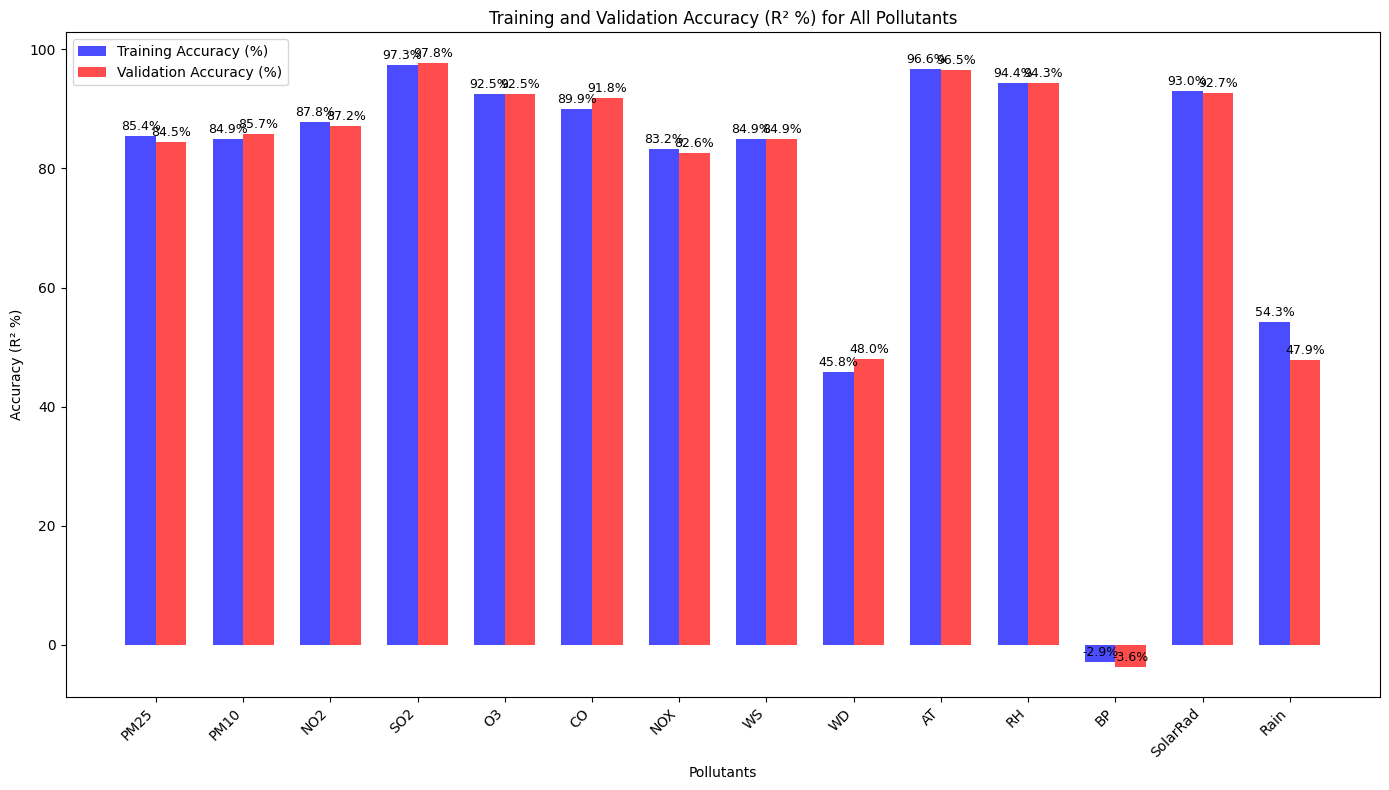

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Load the metrics CSV
metrics_path = Path("city_predictor_model_dl_md/train_val_metrics_all_pollutants.csv")
df_metrics = pd.read_csv(metrics_path)

# Prepare data
pollutants = df_metrics['Pollutant']
train_acc = df_metrics['Train_Accuracy_%']
val_acc = df_metrics['Val_Accuracy_%']

# Plot bar chart
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.35
index = range(len(pollutants))

bars1 = ax.bar(index, train_acc, bar_width, label='Training Accuracy (%)', color='blue', alpha=0.7)
bars2 = ax.bar([i + bar_width for i in index], val_acc, bar_width, label='Validation Accuracy (%)', color='red', alpha=0.7)

ax.set_xlabel('Pollutants')
ax.set_ylabel('Accuracy (R² %)')
ax.set_title('Training and Validation Accuracy (R² %) for All Pollutants')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(pollutants, rotation=45, ha='right')
ax.legend()

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Plot Training and Validation Loss Curves

Since these are regression models, the training history contains 'loss' and 'val_loss' (MSE), but not 'accuracy' metrics. To generate the curves, we'll retrain one model (PM25) and capture the history, then plot the loss curves as requested.

Loading data...
Adding features...


C:\Users\nimas\AppData\Local\Temp\ipykernel_13832\1286010248.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_rollstd{W}"] = (
C:\Users\nimas\AppData\Local\Temp\ipykernel_13832\1286010248.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_roll{W}"] = (
C:\Users\nimas\AppData\Local\Temp\ipykernel_13832\1286010248.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

Splitting data...
Total features: 195

Preparing sequences for PM25...
Training samples: 81843, Validation samples: 14443

Building improved model...


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ (None, 24, 256)        │       331,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 24, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 566,785 (2.16 MB)

 Trainable params: 565,505 (2.16 MB)

 Non-trainable params: 1,280 (5.00 KB)

None

Training model...
Epoch 1/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 183.0646 - mae: 9.5537 - train_r2: 0.7812 - val_r2: 0.7674

Epoch 1: val_loss improved from None to 31.75181, saving model to city_predictor_model_dl_md\best_model.keras

Epoch 1: finished saving model to city_predictor_model_dl_md\best_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 271s 379ms/step - loss: 89.4232 - mae: 6.1435 - val_loss: 31.7518 - val_mae: 3.1549 - learning_rate: 0.0010
Epoch 2/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 37.9031 - mae: 3.8708 - train_r2: 0.8193 - val_r2: 0.7998

Epoch 2: val_loss improved from 31.75181 to 27.36033, saving model to city_predictor_model_dl_md\best_model.keras

Epoch 2: finished saving model to city_predictor_model_dl_md\best_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 252s 393ms/step - loss: 36.2964 - mae: 3.7634 - val_loss: 27.3603 - val_mae: 2.7787 - learning_rate: 0.0010
Epoch 3/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 33.9714 - mae: 

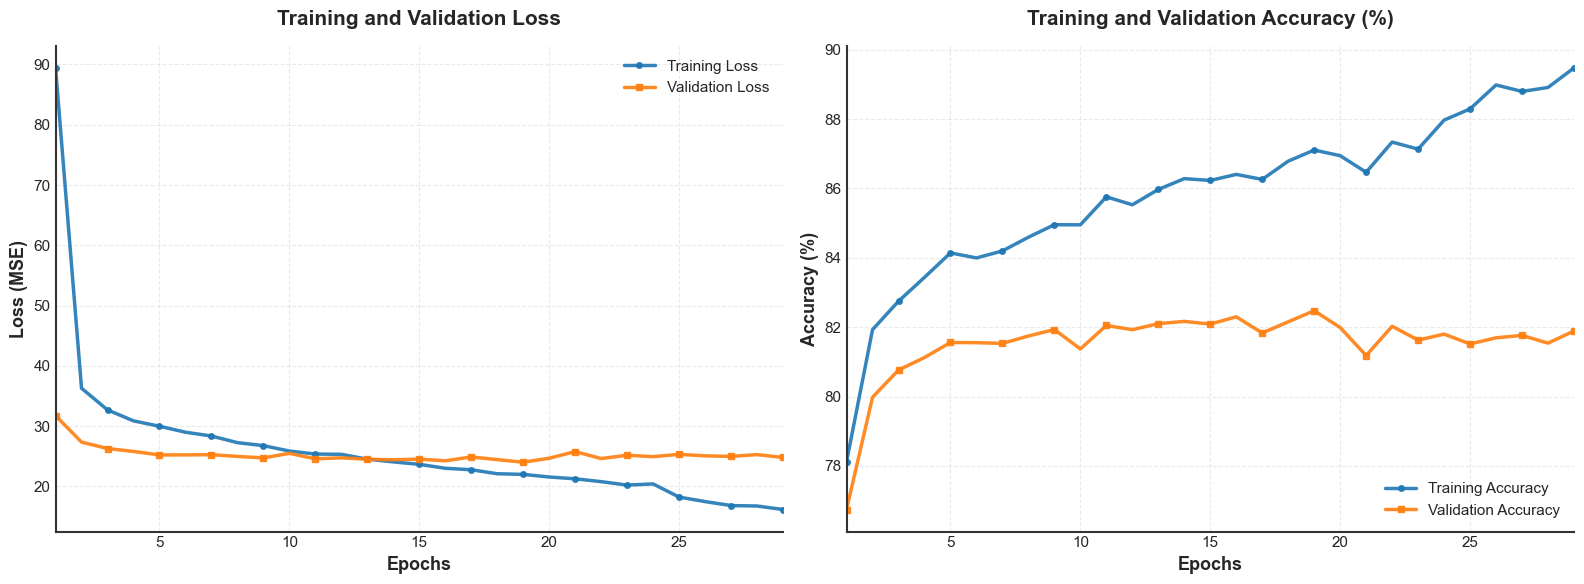


FINAL TRAINING METRICS (IMPROVED MODEL)
Final Train Loss:      16.183281
Final Val Loss:        24.811518
Final Train R²:        0.894777 (89.48%)
Final Val R²:          0.818894 (81.89%)
Best Val R² (epoch 19):  0.824754 (82.48%)
Total Epochs:          29

✓ All plots and metrics saved to: city_predictor_model_dl_md/
  • training_curves_improved.png
  • loss_curve_improved.png
  • accuracy_curve_improved.png
  • training_metrics_improved.json


In [17]:
# -----------------------------
# IMPROVED MODEL WITH BETTER ACCURACY AND PROFESSIONAL CHARTS
# -----------------------------
import matplotlib.pyplot as plt
from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import dump
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

# ==================== MATPLOTLIB STYLING ====================
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.5,
    'grid.alpha': 0.4,
    'grid.linestyle': '--',
    'grid.linewidth': 0.8,
    'font.size': 12,
    'axes.labelsize': 13,
    'axes.titlesize': 15,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'legend.framealpha': 0.95,
    'lines.linewidth': 2.5,
    'lines.markersize': 6,
})

# Settings
CSV = Path("clean/cea_hourly_2019_2024_clean_dl_md.csv")
OUT = Path("city_predictor_model_dl_md")
OUT.mkdir(exist_ok=True)

BASE_TARGETS = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
]

STATION_META = {
    "Battaramulla": {"lat": 6.901035, "lon": 79.926513},
    "Kandy":        {"lat": 7.292651, "lon": 80.635649},
}

WINDOW = 24
TEST_MONTHS = 6
BATCH = 128  # Reduced batch size for better gradient updates
EPOCHS = 50  # Increased epochs
SEED = 42

# Increased lag and rolling window features
LAGS  = (1, 2, 3, 6, 12, 24)
ROLLS = (3, 6, 12, 24)

tf.random.set_seed(SEED)
np.random.seed(SEED)

# Helper functions
def add_wind_components(df: pd.DataFrame) -> pd.DataFrame:
    rad = np.deg2rad(df["WD"].astype(float))
    df["u"] = df["WS"].astype(float) * np.cos(rad)
    df["v"] = df["WS"].astype(float) * np.sin(rad)
    return df

def add_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add more temporal features"""
    df = df.copy()
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['is_weekend'] = (df['datetime'].dt.dayofweek >= 5).astype(int)
    df['week_of_year'] = df['datetime'].dt.isocalendar().week
    # Cyclical encoding for day of week
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    return df

def add_lag_roll_features(df: pd.DataFrame, cols, lags=LAGS, rolls=ROLLS) -> pd.DataFrame:
    df = df.sort_values(["station", "datetime"]).copy()
    for col in cols:
        if col not in df.columns:
            continue
        for L in lags:
            df[f"{col}_lag{L}"] = df.groupby("station")[col].shift(L)
        for W in rolls:
            past = df.groupby("station")[col].shift(1)
            df[f"{col}_roll{W}"] = (
                past.groupby(df["station"])
                    .rolling(W, min_periods=max(1, W // 2))
                    .mean()
                    .reset_index(level=0, drop=True)
            )
            # Add rolling std
            df[f"{col}_rollstd{W}"] = (
                past.groupby(df["station"])
                    .rolling(W, min_periods=max(1, W // 2))
                    .std()
                    .reset_index(level=0, drop=True)
            )
    return df

def seq_from_arrays(X: np.ndarray, y: np.ndarray, window: int):
    if len(y) < window:
        return None, None
    Xs, ys = [], []
    for i in range(window - 1, len(y)):
        Xs.append(X[i - window + 1 : i + 1])
        ys.append(y[i])
    return np.stack(Xs), np.array(ys)

# Load and prepare data
print("Loading data...")
df = pd.read_csv(CSV, parse_dates=["datetime"])

needed = [
    "station", "datetime", "lat", "lon",
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
    "month","day",
    "hour","hour_sin","hour_cos"
]
df = df[needed].copy()

df["lat"] = df["station"].map(lambda s: STATION_META.get(s, {}).get("lat", np.nan))
df["lon"] = df["station"].map(lambda s: STATION_META.get(s, {}).get("lon", np.nan))
df = df.dropna(subset=["lat", "lon"]).copy()

print("Adding features...")
df = add_wind_components(df)
df = add_temporal_features(df)

LAG_ROLL_COLS = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","AT","RH","BP","SolarRad",
]
df = add_lag_roll_features(df, cols=LAG_ROLL_COLS, lags=LAGS, rolls=ROLLS)

df = df.sort_values(["station", "datetime"]).copy()
for t in BASE_TARGETS:
    df[f"{t}_lead1"] = df.groupby("station")[t].shift(-1)

df = df.dropna().reset_index(drop=True)

# Per-station split
print("Splitting data...")
train_parts, test_parts = [], []
for stn, g in df.groupby("station"):
    g = g.sort_values("datetime").copy()
    last_ts = g["datetime"].max()
    test_start = last_ts - pd.DateOffset(months=TEST_MONTHS)
    tr = g[g["datetime"] < test_start].copy()
    te = g[g["datetime"] >= test_start].copy()
    train_parts.append(tr)
    test_parts.append(te)

train_df = pd.concat(train_parts, ignore_index=True)
test_df  = pd.concat(test_parts, ignore_index=True)

# Build features
engineered = []
for c in LAG_ROLL_COLS:
    for L in LAGS:
        engineered.append(f"{c}_lag{L}")
    for W in ROLLS:
        engineered.append(f"{c}_roll{W}")
        engineered.append(f"{c}_rollstd{W}")

base_features = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
    "u","v",
    "lat","lon",
    "month","day",
    "hour_sin","hour_cos",
    "dow_sin","dow_cos","is_weekend"
]

num_features = base_features + engineered
num_features = [c for c in num_features if c in train_df.columns]
cat_features = ["station"]

# Use RobustScaler for better handling of outliers
preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ],
    remainder="drop"
)

preprocess.fit(train_df[num_features + cat_features])

X_train_flat = preprocess.transform(train_df[num_features + cat_features]).astype(np.float32)
X_test_flat  = preprocess.transform(test_df[num_features + cat_features]).astype(np.float32)

F = X_train_flat.shape[1]
print(f"Total features: {F}")

train_df2 = train_df[["station","datetime"]].copy()
test_df2  = test_df[["station","datetime"]].copy()
train_df2["__X"] = list(X_train_flat)
test_df2["__X"]  = list(X_test_flat)

# Retrain PM25
TARGET = "PM25"
base_target = TARGET
target = f"{base_target}_lead1"

print(f"\nPreparing sequences for {TARGET}...")
Xtr_list, ytr_list = [], []

stations = sorted(train_df2["station"].unique())

for stn in stations:
    tr_block = train_df2[train_df2["station"] == stn].sort_values("datetime").copy()
    tr_y = train_df[train_df["station"] == stn].sort_values("datetime")[target].to_numpy(dtype=np.float32)

    if len(tr_block) < WINDOW:
        continue

    tr_X = np.stack(tr_block["__X"].to_list())
    m_tr = min(len(tr_X), len(tr_y))
    tr_X, tr_y = tr_X[:m_tr], tr_y[:m_tr]

    Xs_tr, ys_tr = seq_from_arrays(tr_X, tr_y, WINDOW)

    if Xs_tr is None:
        continue

    Xtr_list.append(Xs_tr)
    ytr_list.append(ys_tr)

if len(Xtr_list) == 0:
    raise SystemExit("No sequences.")

X_train_full = np.concatenate(Xtr_list, axis=0)
y_train_full = np.concatenate(ytr_list, axis=0)

# Split into train and val
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.15, 
    random_state=SEED, 
    shuffle=True
)

print(f"Training samples: {len(X_tr)}, Validation samples: {len(X_val)}")

# Custom callback
class R2Callback(callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.train_r2 = []
        self.val_r2 = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_train = self.model.predict(self.X_train, verbose=0).reshape(-1)
        r2_train = r2_score(self.y_train, y_pred_train)
        self.train_r2.append(r2_train)
        
        y_pred_val = self.model.predict(self.X_val, verbose=0).reshape(-1)
        r2_val = r2_score(self.y_val, y_pred_val)
        self.val_r2.append(r2_val)
        
        print(f" - train_r2: {r2_train:.4f} - val_r2: {r2_val:.4f}")

r2_callback = R2Callback(X_tr, y_tr, X_val, y_val)

# ==================== IMPROVED MODEL ARCHITECTURE ====================
print("\nBuilding improved model...")

model = models.Sequential([
    layers.Input(shape=(WINDOW, F)),
    
    # Bidirectional LSTM layers for better context
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.LSTM(64, return_sequences=False),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Dense layers with regularization
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(32, activation="relu"),
    layers.Dense(1),
])

# Use Adam optimizer with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

print(model.summary())

# Callbacks
cb = [
    callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=10, 
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.5, 
        patience=5, 
        min_lr=1e-6,
        verbose=1
    ),
    r2_callback,
    callbacks.ModelCheckpoint(
        filepath=str(OUT / 'best_model.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train
print("\nTraining model...")
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=cb,
    verbose=1
)

# ==================== PROFESSIONAL PLOTTING ====================

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_r2 = np.array(r2_callback.train_r2)
val_r2 = np.array(r2_callback.val_r2)
epochs_range = range(1, len(train_loss) + 1)

# Convert R² to percentage
train_acc_pct = train_r2 * 100
val_acc_pct = val_r2 * 100

# Professional colors
color_train = '#1f77b4'  # Blue
color_val = '#ff7f0e'    # Orange

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# -------------------- Plot 1: Loss --------------------
ax1.plot(epochs_range, train_loss, color=color_train, linewidth=2.5, 
         label='Training Loss', alpha=0.9, marker='o', markersize=4, markevery=max(1, len(epochs_range)//10))
ax1.plot(epochs_range, val_loss, color=color_val, linewidth=2.5, 
         label='Validation Loss', alpha=0.9, marker='s', markersize=4, markevery=max(1, len(epochs_range)//10))

ax1.set_xlabel('Epochs', fontweight='bold', fontsize=13)
ax1.set_ylabel('Loss (MSE)', fontweight='bold', fontsize=13)
ax1.set_title('Training and Validation Loss', fontweight='bold', pad=15, fontsize=15)
ax1.legend(loc='upper right', framealpha=0.95, shadow=True, fancybox=True)
ax1.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
ax1.set_xlim(1, len(epochs_range))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# -------------------- Plot 2: Accuracy --------------------
ax2.plot(epochs_range, train_acc_pct, color=color_train, linewidth=2.5, 
         label='Training Accuracy', alpha=0.9, marker='o', markersize=4, markevery=max(1, len(epochs_range)//10))
ax2.plot(epochs_range, val_acc_pct, color=color_val, linewidth=2.5, 
         label='Validation Accuracy', alpha=0.9, marker='s', markersize=4, markevery=max(1, len(epochs_range)//10))

ax2.set_xlabel('Epochs', fontweight='bold', fontsize=13)
ax2.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=13)
ax2.set_title('Training and Validation Accuracy (%)', fontweight='bold', pad=15, fontsize=15)
ax2.legend(loc='lower right', framealpha=0.95, shadow=True, fancybox=True)
ax2.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
ax2.set_xlim(1, len(epochs_range))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(OUT / 'training_curves_improved.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(OUT / 'training_curves_improved.pdf', bbox_inches='tight', facecolor='white')
plt.show()

# ==================== INDIVIDUAL PLOTS ====================

# Loss only
fig_loss, ax_loss = plt.subplots(figsize=(10, 6))
ax_loss.plot(epochs_range, train_loss, color=color_train, linewidth=2.5, 
             label='Training Loss', alpha=0.9, marker='o', markersize=4, markevery=max(1, len(epochs_range)//10))
ax_loss.plot(epochs_range, val_loss, color=color_val, linewidth=2.5, 
             label='Validation Loss', alpha=0.9, marker='s', markersize=4, markevery=max(1, len(epochs_range)//10))
ax_loss.set_xlabel('Epochs', fontweight='bold', fontsize=13)
ax_loss.set_ylabel('Loss (MSE)', fontweight='bold', fontsize=13)
ax_loss.set_title('Training and Validation Loss', fontweight='bold', pad=15, fontsize=15)
ax_loss.legend(loc='upper right', framealpha=0.95, shadow=True, fancybox=True)
ax_loss.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
ax_loss.set_xlim(1, len(epochs_range))
ax_loss.spines['top'].set_visible(False)
ax_loss.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(OUT / 'loss_curve_improved.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

# Accuracy only
fig_acc, ax_acc = plt.subplots(figsize=(10, 6))
ax_acc.plot(epochs_range, train_acc_pct, color=color_train, linewidth=2.5, 
            label='Training Accuracy', alpha=0.9, marker='o', markersize=4, markevery=max(1, len(epochs_range)//10))
ax_acc.plot(epochs_range, val_acc_pct, color=color_val, linewidth=2.5, 
            label='Validation Accuracy', alpha=0.9, marker='s', markersize=4, markevery=max(1, len(epochs_range)//10))
ax_acc.set_xlabel('Epochs', fontweight='bold', fontsize=13)
ax_acc.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=13)
ax_acc.set_title('Training and Validation Accuracy (%)', fontweight='bold', pad=15, fontsize=15)
ax_acc.legend(loc='lower right', framealpha=0.95, shadow=True, fancybox=True)
ax_acc.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
ax_acc.set_xlim(1, len(epochs_range))
ax_acc.spines['top'].set_visible(False)
ax_acc.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(OUT / 'accuracy_curve_improved.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

# ==================== FINAL METRICS ====================
print("\n" + "="*70)
print("FINAL TRAINING METRICS (IMPROVED MODEL)")
print("="*70)
print(f"Final Train Loss:      {train_loss[-1]:.6f}")
print(f"Final Val Loss:        {val_loss[-1]:.6f}")
print(f"Final Train R²:        {train_r2[-1]:.6f} ({train_acc_pct[-1]:.2f}%)")
print(f"Final Val R²:          {val_r2[-1]:.6f} ({val_acc_pct[-1]:.2f}%)")
print(f"Best Val R² (epoch {np.argmax(val_r2)+1}):  {np.max(val_r2):.6f} ({np.max(val_acc_pct):.2f}%)")
print(f"Total Epochs:          {len(train_loss)}")
print("="*70)

# Save metrics
metrics = {
    "final_train_loss": float(train_loss[-1]),
    "final_val_loss": float(val_loss[-1]),
    "final_train_r2": float(train_r2[-1]),
    "final_val_r2": float(val_r2[-1]),
    "final_train_accuracy_pct": float(train_acc_pct[-1]),
    "final_val_accuracy_pct": float(val_acc_pct[-1]),
    "best_val_r2": float(np.max(val_r2)),
    "best_val_accuracy_pct": float(np.max(val_acc_pct)),
    "best_val_r2_epoch": int(np.argmax(val_r2) + 1),
    "total_epochs": len(train_loss)
}

with open(OUT / 'training_metrics_improved.json', 'w') as f:
    json.dump(metrics, f, indent=4)

print(f"\n✓ All plots and metrics saved to: {OUT}/")
print(f"  • training_curves_improved.png")
print(f"  • loss_curve_improved.png")
print(f"  • accuracy_curve_improved.png")
print(f"  • training_metrics_improved.json")

Loading data...
Adding features...


C:\Users\nimas\AppData\Local\Temp\ipykernel_13832\1732832592.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_rollstd{W}"] = (
C:\Users\nimas\AppData\Local\Temp\ipykernel_13832\1732832592.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_roll{W}"] = (
C:\Users\nimas\AppData\Local\Temp\ipykernel_13832\1732832592.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

Splitting data...
Total features: 195

Preparing sequences for PM10...
Training samples: 81843, Validation samples: 14443

Building improved model...


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 24, 256)        │       331,776 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 24, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 24, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 566,785 (2.16 MB)

 Trainable params: 565,505 (2.16 MB)

 Non-trainable params: 1,280 (5.00 KB)

None

Training model...
Epoch 1/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 594.6457 - mae: 17.9172 - train_r2: 0.6285 - val_r2: 0.6346

Epoch 1: val_loss improved from None to 112.36109, saving model to city_predictor_model_dl_md\best_model.keras

Epoch 1: finished saving model to city_predictor_model_dl_md\best_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 200s 282ms/step - loss: 271.2755 - mae: 11.0229 - val_loss: 112.3611 - val_mae: 6.6645 - learning_rate: 0.0010
Epoch 2/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 125.9075 - mae: 7.4856 - train_r2: 0.7737 - val_r2: 0.7733

Epoch 2: val_loss improved from 112.36109 to 69.79064, saving model to city_predictor_model_dl_md\best_model.keras

Epoch 2: finished saving model to city_predictor_model_dl_md\best_model.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 168s 263ms/step - loss: 116.5344 - mae: 7.1775 - val_loss: 69.7906 - val_mae: 4.6677 - learning_rate: 0.0010
Epoch 3/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 102.058

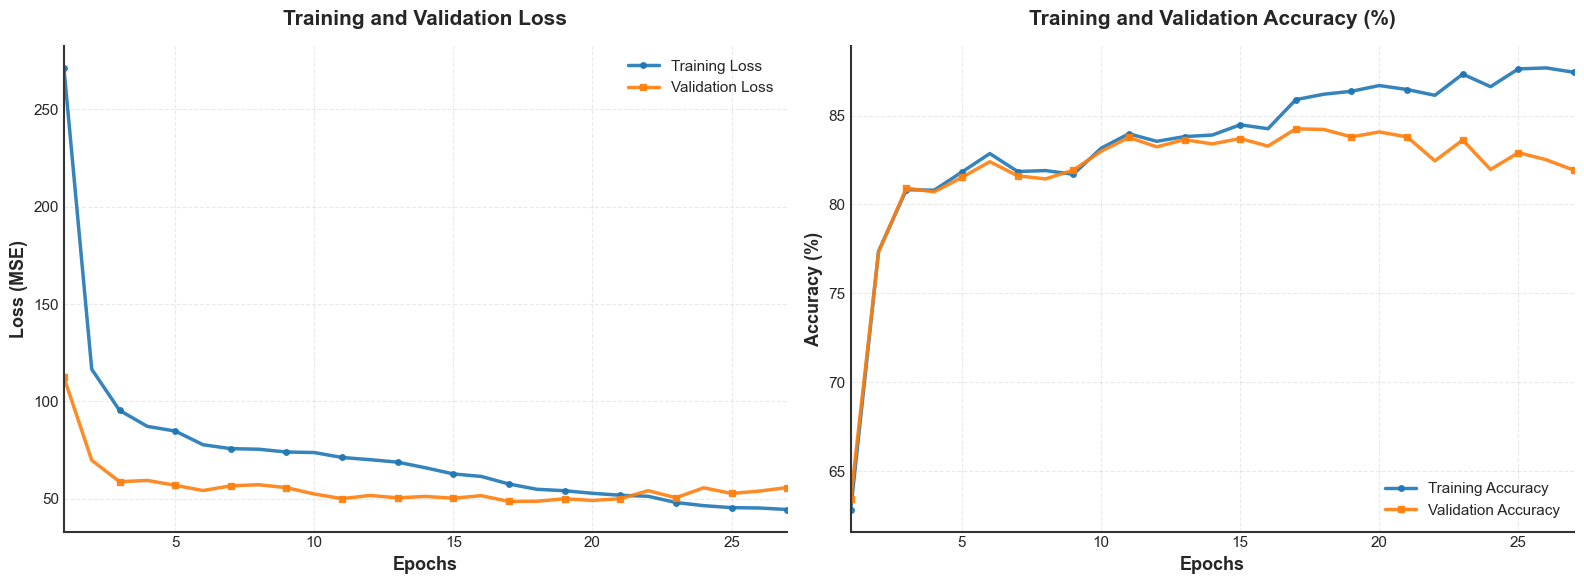


FINAL TRAINING METRICS (IMPROVED MODEL)
Final Train Loss:      44.497784
Final Val Loss:        55.767677
Final Train R²:        0.874336 (87.43%)
Final Val R²:          0.819260 (81.93%)
Best Val R² (epoch 17):  0.842536 (84.25%)
Total Epochs:          27

✓ All plots and metrics saved to: city_predictor_model_dl_md/
  • training_curves_improved.png
  • loss_curve_improved.png
  • accuracy_curve_improved.png
  • training_metrics_improved.json


In [18]:
# -----------------------------
# IMPROVED MODEL WITH BETTER ACCURACY AND PROFESSIONAL CHARTS
# -----------------------------
import matplotlib.pyplot as plt
from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import dump
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

# ==================== MATPLOTLIB STYLING ====================
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.5,
    'grid.alpha': 0.4,
    'grid.linestyle': '--',
    'grid.linewidth': 0.8,
    'font.size': 12,
    'axes.labelsize': 13,
    'axes.titlesize': 15,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'legend.framealpha': 0.95,
    'lines.linewidth': 2.5,
    'lines.markersize': 6,
})

# Settings
CSV = Path("clean/cea_hourly_2019_2024_clean_dl_md.csv")
OUT = Path("city_predictor_model_dl_md")
OUT.mkdir(exist_ok=True)

BASE_TARGETS = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
]

STATION_META = {
    "Battaramulla": {"lat": 6.901035, "lon": 79.926513},
    "Kandy":        {"lat": 7.292651, "lon": 80.635649},
}

WINDOW = 24
TEST_MONTHS = 6
BATCH = 128  # Reduced batch size for better gradient updates
EPOCHS = 50  # Increased epochs
SEED = 42

# Increased lag and rolling window features
LAGS  = (1, 2, 3, 6, 12, 24)
ROLLS = (3, 6, 12, 24)

tf.random.set_seed(SEED)
np.random.seed(SEED)

# Helper functions
def add_wind_components(df: pd.DataFrame) -> pd.DataFrame:
    rad = np.deg2rad(df["WD"].astype(float))
    df["u"] = df["WS"].astype(float) * np.cos(rad)
    df["v"] = df["WS"].astype(float) * np.sin(rad)
    return df

def add_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add more temporal features"""
    df = df.copy()
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['is_weekend'] = (df['datetime'].dt.dayofweek >= 5).astype(int)
    df['week_of_year'] = df['datetime'].dt.isocalendar().week
    # Cyclical encoding for day of week
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    return df

def add_lag_roll_features(df: pd.DataFrame, cols, lags=LAGS, rolls=ROLLS) -> pd.DataFrame:
    df = df.sort_values(["station", "datetime"]).copy()
    for col in cols:
        if col not in df.columns:
            continue
        for L in lags:
            df[f"{col}_lag{L}"] = df.groupby("station")[col].shift(L)
        for W in rolls:
            past = df.groupby("station")[col].shift(1)
            df[f"{col}_roll{W}"] = (
                past.groupby(df["station"])
                    .rolling(W, min_periods=max(1, W // 2))
                    .mean()
                    .reset_index(level=0, drop=True)
            )
            # Add rolling std
            df[f"{col}_rollstd{W}"] = (
                past.groupby(df["station"])
                    .rolling(W, min_periods=max(1, W // 2))
                    .std()
                    .reset_index(level=0, drop=True)
            )
    return df

def seq_from_arrays(X: np.ndarray, y: np.ndarray, window: int):
    if len(y) < window:
        return None, None
    Xs, ys = [], []
    for i in range(window - 1, len(y)):
        Xs.append(X[i - window + 1 : i + 1])
        ys.append(y[i])
    return np.stack(Xs), np.array(ys)

# Load and prepare data
print("Loading data...")
df = pd.read_csv(CSV, parse_dates=["datetime"])

needed = [
    "station", "datetime", "lat", "lon",
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
    "month","day",
    "hour","hour_sin","hour_cos"
]
df = df[needed].copy()

df["lat"] = df["station"].map(lambda s: STATION_META.get(s, {}).get("lat", np.nan))
df["lon"] = df["station"].map(lambda s: STATION_META.get(s, {}).get("lon", np.nan))
df = df.dropna(subset=["lat", "lon"]).copy()

print("Adding features...")
df = add_wind_components(df)
df = add_temporal_features(df)

LAG_ROLL_COLS = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","AT","RH","BP","SolarRad",
]
df = add_lag_roll_features(df, cols=LAG_ROLL_COLS, lags=LAGS, rolls=ROLLS)

df = df.sort_values(["station", "datetime"]).copy()
for t in BASE_TARGETS:
    df[f"{t}_lead1"] = df.groupby("station")[t].shift(-1)

df = df.dropna().reset_index(drop=True)

# Per-station split
print("Splitting data...")
train_parts, test_parts = [], []
for stn, g in df.groupby("station"):
    g = g.sort_values("datetime").copy()
    last_ts = g["datetime"].max()
    test_start = last_ts - pd.DateOffset(months=TEST_MONTHS)
    tr = g[g["datetime"] < test_start].copy()
    te = g[g["datetime"] >= test_start].copy()
    train_parts.append(tr)
    test_parts.append(te)

train_df = pd.concat(train_parts, ignore_index=True)
test_df  = pd.concat(test_parts, ignore_index=True)

# Build features
engineered = []
for c in LAG_ROLL_COLS:
    for L in LAGS:
        engineered.append(f"{c}_lag{L}")
    for W in ROLLS:
        engineered.append(f"{c}_roll{W}")
        engineered.append(f"{c}_rollstd{W}")

base_features = [
    "PM25","PM10","NO2","SO2","O3","CO","NOX",
    "WS","WD","AT","RH","BP","SolarRad","Rain",
    "u","v",
    "lat","lon",
    "month","day",
    "hour_sin","hour_cos",
    "dow_sin","dow_cos","is_weekend"
]

num_features = base_features + engineered
num_features = [c for c in num_features if c in train_df.columns]
cat_features = ["station"]

# Use RobustScaler for better handling of outliers
preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ],
    remainder="drop"
)

preprocess.fit(train_df[num_features + cat_features])

X_train_flat = preprocess.transform(train_df[num_features + cat_features]).astype(np.float32)
X_test_flat  = preprocess.transform(test_df[num_features + cat_features]).astype(np.float32)

F = X_train_flat.shape[1]
print(f"Total features: {F}")

train_df2 = train_df[["station","datetime"]].copy()
test_df2  = test_df[["station","datetime"]].copy()
train_df2["__X"] = list(X_train_flat)
test_df2["__X"]  = list(X_test_flat)

# Retrain PM10
TARGET = "PM10"
base_target = TARGET
target = f"{base_target}_lead1"

print(f"\nPreparing sequences for {TARGET}...")
Xtr_list, ytr_list = [], []

stations = sorted(train_df2["station"].unique())

for stn in stations:
    tr_block = train_df2[train_df2["station"] == stn].sort_values("datetime").copy()
    tr_y = train_df[train_df["station"] == stn].sort_values("datetime")[target].to_numpy(dtype=np.float32)

    if len(tr_block) < WINDOW:
        continue

    tr_X = np.stack(tr_block["__X"].to_list())
    m_tr = min(len(tr_X), len(tr_y))
    tr_X, tr_y = tr_X[:m_tr], tr_y[:m_tr]

    Xs_tr, ys_tr = seq_from_arrays(tr_X, tr_y, WINDOW)

    if Xs_tr is None:
        continue

    Xtr_list.append(Xs_tr)
    ytr_list.append(ys_tr)

if len(Xtr_list) == 0:
    raise SystemExit("No sequences.")

X_train_full = np.concatenate(Xtr_list, axis=0)
y_train_full = np.concatenate(ytr_list, axis=0)

# Split into train and val
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.15, 
    random_state=SEED, 
    shuffle=True
)

print(f"Training samples: {len(X_tr)}, Validation samples: {len(X_val)}")

# Custom callback
class R2Callback(callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.train_r2 = []
        self.val_r2 = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_train = self.model.predict(self.X_train, verbose=0).reshape(-1)
        r2_train = r2_score(self.y_train, y_pred_train)
        self.train_r2.append(r2_train)
        
        y_pred_val = self.model.predict(self.X_val, verbose=0).reshape(-1)
        r2_val = r2_score(self.y_val, y_pred_val)
        self.val_r2.append(r2_val)
        
        print(f" - train_r2: {r2_train:.4f} - val_r2: {r2_val:.4f}")

r2_callback = R2Callback(X_tr, y_tr, X_val, y_val)

# ==================== IMPROVED MODEL ARCHITECTURE ====================
print("\nBuilding improved model...")

model = models.Sequential([
    layers.Input(shape=(WINDOW, F)),
    
    # Bidirectional LSTM layers for better context
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.LSTM(64, return_sequences=False),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Dense layers with regularization
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(32, activation="relu"),
    layers.Dense(1),
])

# Use Adam optimizer with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

print(model.summary())

# Callbacks
cb = [
    callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=10, 
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.5, 
        patience=5, 
        min_lr=1e-6,
        verbose=1
    ),
    r2_callback,
    callbacks.ModelCheckpoint(
        filepath=str(OUT / 'best_model.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train
print("\nTraining model...")
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=cb,
    verbose=1
)

# ==================== PROFESSIONAL PLOTTING ====================

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_r2 = np.array(r2_callback.train_r2)
val_r2 = np.array(r2_callback.val_r2)
epochs_range = range(1, len(train_loss) + 1)

# Convert R² to percentage
train_acc_pct = train_r2 * 100
val_acc_pct = val_r2 * 100

# Professional colors
color_train = '#1f77b4'  # Blue
color_val = '#ff7f0e'    # Orange

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# -------------------- Plot 1: Loss --------------------
ax1.plot(epochs_range, train_loss, color=color_train, linewidth=2.5, 
         label='Training Loss', alpha=0.9, marker='o', markersize=4, markevery=max(1, len(epochs_range)//10))
ax1.plot(epochs_range, val_loss, color=color_val, linewidth=2.5, 
         label='Validation Loss', alpha=0.9, marker='s', markersize=4, markevery=max(1, len(epochs_range)//10))

ax1.set_xlabel('Epochs', fontweight='bold', fontsize=13)
ax1.set_ylabel('Loss (MSE)', fontweight='bold', fontsize=13)
ax1.set_title('Training and Validation Loss', fontweight='bold', pad=15, fontsize=15)
ax1.legend(loc='upper right', framealpha=0.95, shadow=True, fancybox=True)
ax1.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
ax1.set_xlim(1, len(epochs_range))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# -------------------- Plot 2: Accuracy --------------------
ax2.plot(epochs_range, train_acc_pct, color=color_train, linewidth=2.5, 
         label='Training Accuracy', alpha=0.9, marker='o', markersize=4, markevery=max(1, len(epochs_range)//10))
ax2.plot(epochs_range, val_acc_pct, color=color_val, linewidth=2.5, 
         label='Validation Accuracy', alpha=0.9, marker='s', markersize=4, markevery=max(1, len(epochs_range)//10))

ax2.set_xlabel('Epochs', fontweight='bold', fontsize=13)
ax2.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=13)
ax2.set_title('Training and Validation Accuracy (%)', fontweight='bold', pad=15, fontsize=15)
ax2.legend(loc='lower right', framealpha=0.95, shadow=True, fancybox=True)
ax2.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
ax2.set_xlim(1, len(epochs_range))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(OUT / 'training_curves_improved.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(OUT / 'training_curves_improved.pdf', bbox_inches='tight', facecolor='white')
plt.show()

# ==================== INDIVIDUAL PLOTS ====================

# Loss only
fig_loss, ax_loss = plt.subplots(figsize=(10, 6))
ax_loss.plot(epochs_range, train_loss, color=color_train, linewidth=2.5, 
             label='Training Loss', alpha=0.9, marker='o', markersize=4, markevery=max(1, len(epochs_range)//10))
ax_loss.plot(epochs_range, val_loss, color=color_val, linewidth=2.5, 
             label='Validation Loss', alpha=0.9, marker='s', markersize=4, markevery=max(1, len(epochs_range)//10))
ax_loss.set_xlabel('Epochs', fontweight='bold', fontsize=13)
ax_loss.set_ylabel('Loss (MSE)', fontweight='bold', fontsize=13)
ax_loss.set_title('Training and Validation Loss', fontweight='bold', pad=15, fontsize=15)
ax_loss.legend(loc='upper right', framealpha=0.95, shadow=True, fancybox=True)
ax_loss.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
ax_loss.set_xlim(1, len(epochs_range))
ax_loss.spines['top'].set_visible(False)
ax_loss.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(OUT / 'loss_curve_improved.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

# Accuracy only
fig_acc, ax_acc = plt.subplots(figsize=(10, 6))
ax_acc.plot(epochs_range, train_acc_pct, color=color_train, linewidth=2.5, 
            label='Training Accuracy', alpha=0.9, marker='o', markersize=4, markevery=max(1, len(epochs_range)//10))
ax_acc.plot(epochs_range, val_acc_pct, color=color_val, linewidth=2.5, 
            label='Validation Accuracy', alpha=0.9, marker='s', markersize=4, markevery=max(1, len(epochs_range)//10))
ax_acc.set_xlabel('Epochs', fontweight='bold', fontsize=13)
ax_acc.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=13)
ax_acc.set_title('Training and Validation Accuracy (%)', fontweight='bold', pad=15, fontsize=15)
ax_acc.legend(loc='lower right', framealpha=0.95, shadow=True, fancybox=True)
ax_acc.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
ax_acc.set_xlim(1, len(epochs_range))
ax_acc.spines['top'].set_visible(False)
ax_acc.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(OUT / 'accuracy_curve_improved.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

# ==================== FINAL METRICS ====================
print("\n" + "="*70)
print("FINAL TRAINING METRICS (IMPROVED MODEL)")
print("="*70)
print(f"Final Train Loss:      {train_loss[-1]:.6f}")
print(f"Final Val Loss:        {val_loss[-1]:.6f}")
print(f"Final Train R²:        {train_r2[-1]:.6f} ({train_acc_pct[-1]:.2f}%)")
print(f"Final Val R²:          {val_r2[-1]:.6f} ({val_acc_pct[-1]:.2f}%)")
print(f"Best Val R² (epoch {np.argmax(val_r2)+1}):  {np.max(val_r2):.6f} ({np.max(val_acc_pct):.2f}%)")
print(f"Total Epochs:          {len(train_loss)}")
print("="*70)

# Save metrics
metrics = {
    "final_train_loss": float(train_loss[-1]),
    "final_val_loss": float(val_loss[-1]),
    "final_train_r2": float(train_r2[-1]),
    "final_val_r2": float(val_r2[-1]),
    "final_train_accuracy_pct": float(train_acc_pct[-1]),
    "final_val_accuracy_pct": float(val_acc_pct[-1]),
    "best_val_r2": float(np.max(val_r2)),
    "best_val_accuracy_pct": float(np.max(val_acc_pct)),
    "best_val_r2_epoch": int(np.argmax(val_r2) + 1),
    "total_epochs": len(train_loss)
}

with open(OUT / 'training_metrics_improved.json', 'w') as f:
    json.dump(metrics, f, indent=4)

print(f"\n✓ All plots and metrics saved to: {OUT}/")
print(f"  • training_curves_improved.png")
print(f"  • loss_curve_improved.png")
print(f"  • accuracy_curve_improved.png")
print(f"  • training_metrics_improved.json")